In [1]:
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import auc_score

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

/Users/davidwang/opt/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# read in ratings.txt and documents.txt into pandas

# ratings dataframe
rating_raw = pd.read_csv('fairgrecs-dataset/ratings.txt', sep = '\t', header = [0])

rating_raw = rating_raw.truncate(50, 50000) #matching with other datasets

# user features dataframe (features of keyword)
doc_raw = pd.read_csv('fairgrecs-dataset/documents.txt', sep = '\t', header = [0])


# with open('fairgrecs-dataset/ratings.txt') as f:
#     ratings_lines = f.readlines()
# f.close()

# with open('fairgrecs-dataset/documents.txt') as f:
#     doc_lines = f.readlines()
# f.close()

print("ratings")
print(rating_raw.head)
print("documents")
print(doc_raw.head)

ratings
<bound method NDFrame.head of                                     USER_ID  DOCUMENT_ID  RATE
50     C734A1D1-7592-4E5D-BB37-467E0362E61B        78311     3
51     C734A1D1-7592-4E5D-BB37-467E0362E61B        50280     1
52     C734A1D1-7592-4E5D-BB37-467E0362E61B        73192     1
53     C734A1D1-7592-4E5D-BB37-467E0362E61B        68331     1
54     C734A1D1-7592-4E5D-BB37-467E0362E61B        55915     1
...                                     ...          ...   ...
49996  295EE9CA-CFE6-436B-B394-B68E69C5604C         7601     4
49997  295EE9CA-CFE6-436B-B394-B68E69C5604C        57780     4
49998  295EE9CA-CFE6-436B-B394-B68E69C5604C         2490     5
49999  295EE9CA-CFE6-436B-B394-B68E69C5604C        32192     5
50000  295EE9CA-CFE6-436B-B394-B68E69C5604C        28103     2

[49951 rows x 3 columns]>
documents
<bound method NDFrame.head of        DOCUMENT_ID                                         {KEYWORDS}
0                0       [ Human disease HIV immunodeficiency virus ]

In [3]:
# passing in users and items
users = rating_raw['USER_ID'].values.flatten()
items = rating_raw['DOCUMENT_ID'].values.flatten()
ratings = rating_raw['RATE'].values.flatten()

# passing in user features 
feature_name = doc_raw['{KEYWORDS}'].values.flatten()
feature_value = doc_raw['DOCUMENT_ID'].values.flatten()

In [4]:
dataset = Dataset()
dataset.fit(users, items)

In [5]:
dataset.fit_partial(items = feature_value, item_features = feature_name)

In [6]:
# build in interactions and weights
(interactions, weights) = dataset.build_interactions([(x[0], x[1], x[2]) for x in rating_raw.values ])

In [7]:
# cross_validate

train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.25)
train_weights, test_weights = cross_validation.random_train_test_split(weights, test_percentage=0.25)


In [20]:
# model

alpha = 1e-05
epochs = 30
num_components = 30

health_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=100,
                    user_alpha=alpha,
                    item_alpha=alpha,
                    learning_rate = 0.01 ) # had to decrease learning rate to increase accuracy per epoch

In [21]:
health_auc = []

for epoch in range(epochs):
    health_model.fit_partial(train, epochs=1)
    health_auc.append(auc_score(health_model, test, train_interactions=train).mean())
    

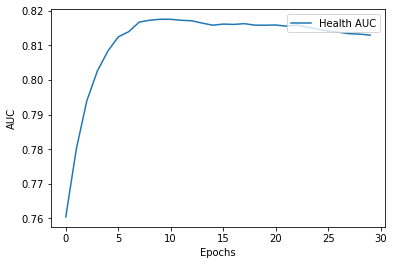

In [36]:
#graph

x = np.arange(epochs)

plt.plot(x, np.array(health_auc))
plt.xlabel('Epochs')
plt.ylabel('AUC')

plt.legend(['Health AUC'], loc = 'upper right')

plt.savefig('Hybrid_Model_Health.png', facecolor = 'w')